In [108]:
from pathlib import Path as pt
from uncertainties import ufloat, ufloat_fromstr
import umap
import plotly.express as px

import pandas as pd
import numpy as np
from rdkit import Chem
from collections import Counter
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from typing import List, Dict, Tuple
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm.notebook import tqdm as tqdm_notebook

warnings.filterwarnings('ignore')
tqdm.pandas()


In [177]:
from load_data import processed_data_dirs, plots_dir
processed_data_dirs

[PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tbp_C_processed_data/analysis_data/filtered/tbp_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/vp_kPa_25C_filtered_ydata_processed_data/analysis_data/filtered/vp_kPa_25C_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[CRITICAL CONSTANTS OF ORGANIC COMPOUNDS]/Pc_MPa_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology

True vp_kPa_25C_topelements.csv
398 smiles
True processed_mol2vec_embeddings
(398, 300)
Scaling embeddings...
Performing UMAP...
(398, 2)
Plotting UMAP...


Text(0, 0.5, 'UMAP2')

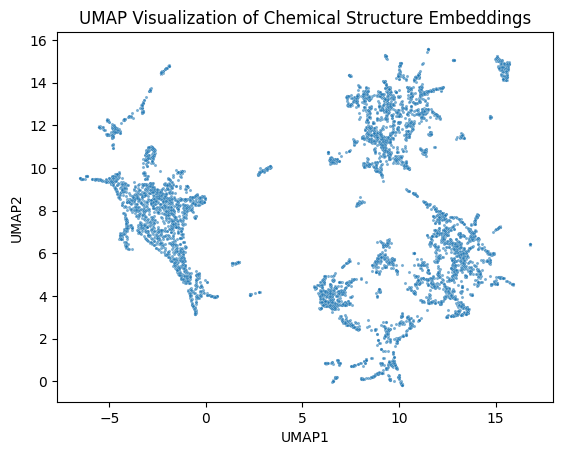

In [111]:
plt.figure()
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    alpha=0.6,
    s=5
)

plt.title('UMAP Visualization of Chemical Structure Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [105]:
class ChemicalClusterAnalyzer:
    """Analyzes chemical structure clusters and their functional groups."""
    
    def __init__(self):
        # Define common functional groups and their SMARTS patterns
        self.functional_groups = {
            'Alcohol': '[OH]',
            'Carboxylic Acid': '[CX3](=O)[OX2H1]',
            'Ester': '[#6][CX3](=O)[OX2H0][#6]',
            'Ether': '[OD2]([#6])[#6]',
            'Aldehyde': '[CX3H1](=O)[#6]',
            'Ketone': '[#6][CX3](=O)[#6]',
            'Amine': '[NX3;H2,H1;!$(NC=O)]',
            'Amide': '[NX3][CX3](=[OX1])[#6]',
            'Aromatic': 'a1aaaaa1',
            'Alkene': '[CX3]=[CX3]',
            'Alkyne': '[CX2]#[CX2]',
            'Nitrile': '[NX1]#[CX2]',
            'Nitro': '[NX3](=O)=O',
            'Sulfonic Acid': '[SX4](=[OX1])(=[OX1])[OX2H]',
            'Phosphate': '[PX4](=[OX1])([OX2H])([OX2H])[OX2H]',
            'Halogen': '[F,Cl,Br,I]'
        }
    
    def identify_functional_groups(self, smiles: str) -> Dict[str, int]:
        """
        Identifies functional groups in a molecule.
        
        Args:
            smiles: SMILES string of the molecule
            
        Returns:
            Dictionary of functional group counts
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {}
            
            groups = {}
            for name, smarts in self.functional_groups.items():
                pattern = Chem.MolFromSmarts(smarts)
                if pattern is not None:
                    matches = mol.GetSubstructMatches(pattern)
                    if matches:
                        groups[name] = len(matches)
            return groups
        except:
            return {}

    def analyze_cluster_chemistry(self, 
                                reduced_embeddings: np.ndarray, 
                                smiles_list: List[str], 
                                eps: float = 0.5, 
                                min_samples: int = 5) -> Tuple[np.ndarray, Dict]:
        """
        Performs clustering and analyzes chemical features of each cluster.
        
        Args:
            reduced_embeddings: UMAP-reduced embeddings
            smiles_list: List of SMILES strings
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN minimum samples parameter
            
        Returns:
            Cluster labels and cluster analysis results
        """
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_embeddings)
        labels = clustering.labels_
        
        # Analyze each cluster
        cluster_analysis = {}
        for cluster_id in tqdm(set(labels)):
            if cluster_id == -1:  # Skip noise points
                continue
                
            # Get SMILES strings for this cluster
            cluster_mask = labels == cluster_id
            cluster_smiles = np.array(smiles_list)[cluster_mask]
            
            # Analyze functional groups
            all_groups = []
            for smiles in cluster_smiles:
                groups = self.identify_functional_groups(smiles)
                all_groups.extend(groups.keys())
            
            # Calculate group frequencies
            group_freq = Counter(all_groups)
            total_mols = len(cluster_smiles)
            group_freq = {k: v/total_mols for k, v in group_freq.items()}
            
            # Store analysis results
            cluster_analysis[cluster_id] = {
                'size': sum(cluster_mask),
                'functional_groups': group_freq,
                'center': reduced_embeddings[cluster_mask].mean(axis=0)
            }
        
        return labels, cluster_analysis

    def plot_cluster_analysis(self, 
                            reduced_embeddings: np.ndarray,
                            smiles_list: List[str],
                            labels: np.ndarray,
                            cluster_analysis: Dict,
                            output_path: str = None):
        """
        Creates an interactive visualization of clusters with chemical analysis.
        
        Args:
            reduced_embeddings: UMAP-reduced embeddings
            smiles_list: List of SMILES strings
            labels: Cluster labels
            cluster_analysis: Cluster analysis results
            output_path: Path to save the plot
        """
        # Create DataFrame for plotting
        df_plot = pd.DataFrame({
            'UMAP1': reduced_embeddings[:, 0],
            'UMAP2': reduced_embeddings[:, 1],
            'Cluster': labels,
            'SMILES': smiles_list
        })
        
        # Create interactive plot
        fig = go.Figure()
        
        # Add scatter points for each cluster
        for cluster_id in set(labels):
            if cluster_id == -1:
                continue # Skip noise points
            cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
            
            # Get dominant functional groups for hover text
            if cluster_id in cluster_analysis:
                top_groups = sorted(
                    cluster_analysis[cluster_id]['functional_groups'].items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:3]
                hover_text = [
                    f"SMILES: {s}<br>Cluster: {cluster_id}<br>" +
                    "<br>".join([f"{g}: {v:.1%}" for g, v in top_groups])
                    for s in cluster_data['SMILES']
                ]
            else:
                hover_text = [f"SMILES: {s}<br>Cluster: Noise" for s in cluster_data['SMILES']]
            
            fig.add_trace(go.Scatter(
                x=cluster_data['UMAP1'],
                y=cluster_data['UMAP2'],
                mode='markers',
                name=f'Cluster {cluster_id}',
                text=hover_text,
                hoverinfo='text',
                marker=dict(size=8)
            ))
        
        # Add cluster annotations
        for cluster_id, info in cluster_analysis.items():
            center = info['center']
            top_groups = sorted(
                info['functional_groups'].items(),
                key=lambda x: x[1],
                reverse=True
            )[:3]
            
            annotation_text = f"Cluster {cluster_id}<br>" + "<br>".join(
                [f"{g}: {v:.1%}" for g, v in top_groups]
            )
            
            fig.add_annotation(
                x=center[0],
                y=center[1],
                text=annotation_text,
                showarrow=True,
                arrowhead=1,
                bgcolor='white',
                bordercolor='black',
                borderwidth=1
            )
        
        # Update layout
        fig.update_layout(
            title='Chemical Structure Clusters Analysis',
            template='plotly_white',
            width=1200,
            height=800,
            showlegend=True,
            hovermode='closest'
        )
        
        if output_path:
            fig.write_html(output_path)
        else:
            fig.show()

In [200]:
ind = 3
embeddings = 'mol2vec'

current_dir = processed_data_dirs[ind]
fname = current_dir.name.replace('_processed_data', '')
csv_file = current_dir.parent / f'{fname}.csv'
print(csv_file.exists(), csv_file.name)

df = pd.read_csv(csv_file)
smiles_list = df['SMILES'].to_list()
print(len(smiles_list), 'smiles')

vec_dir = current_dir / f'embedded_vectors/processed_{embeddings}_embeddings'
print(vec_dir.exists(), vec_dir.name)

X = np.load(vec_dir / 'processed.X.npy', allow_pickle=True)
print(X.shape)


# Scale embeddings
print("Scaling embeddings...")
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(X)

# Perform UMAP
print("Performing UMAP...")

n_neighbors = 15
min_dist = 0.1
n_components = 2

reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    n_jobs=-1,
    # random_state=random_state
)
    
reduced_embeddings = reducer.fit_transform(scaled_embeddings)
print(reduced_embeddings.shape)

cluster_eps: float = 0.5
cluster_min_samples: int = 5

print("Analyzing chemical clusters...")
analyzer = ChemicalClusterAnalyzer()
labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
    reduced_embeddings,
    smiles_list,
    eps=cluster_eps,
    min_samples=cluster_min_samples
)


# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Cluster': labels,
    'SMILES': smiles_list
})

# Create interactive plot
fig = go.Figure()

# Add scatter points for each cluster
for cluster_id in set(labels):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    
    # Get dominant functional groups for hover text
    if cluster_id in cluster_analysis:
        top_groups = sorted(
            cluster_analysis[cluster_id]['functional_groups'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        hover_text = [
            f"SMILES: {s}<br>Cluster: {cluster_id}<br>" +
            "<br>".join([f"{g}: {v:.1%}" for g, v in top_groups])
            for s in cluster_data['SMILES']
        ]
    else:
        hover_text = [f"SMILES: {s}<br>Cluster: Noise" for s in cluster_data['SMILES']]
    
    fig.add_trace(go.Scatter(
        x=cluster_data['UMAP1'],
        y=cluster_data['UMAP2'],
        mode='markers',
        name=f'Cluster {cluster_id}',
        text=hover_text,
        hoverinfo='text',
        marker=dict(size=8)
    ))

# Update layout
fig.update_layout(
    title='Chemical Structure Clusters Analysis',
    template='plotly_white',
    width=1200,
    height=800,
    showlegend=True,
    hovermode='closest'
)
save_path = plots_dir / f'{fname}_umap_clusters.html'
fig.write_html(save_path)
print(f"Cluster analysis plot saved to: {save_path.name}")
fig.show()

True Pc_MPa.csv
777 smiles
True processed_mol2vec_embeddings
(777, 300)
Scaling embeddings...
Performing UMAP...
(777, 2)
Analyzing chemical clusters...


100%|██████████| 9/9 [00:00<00:00, 65.63it/s]

Cluster analysis plot saved to: Pc_MPa_umap_clusters.html


Cluster analysis plot saved to: vp_kPa_25C_topelements_umap_clusters.html


Saved plot to vp_kPa_25C_topelements_umap_clusters.pdf


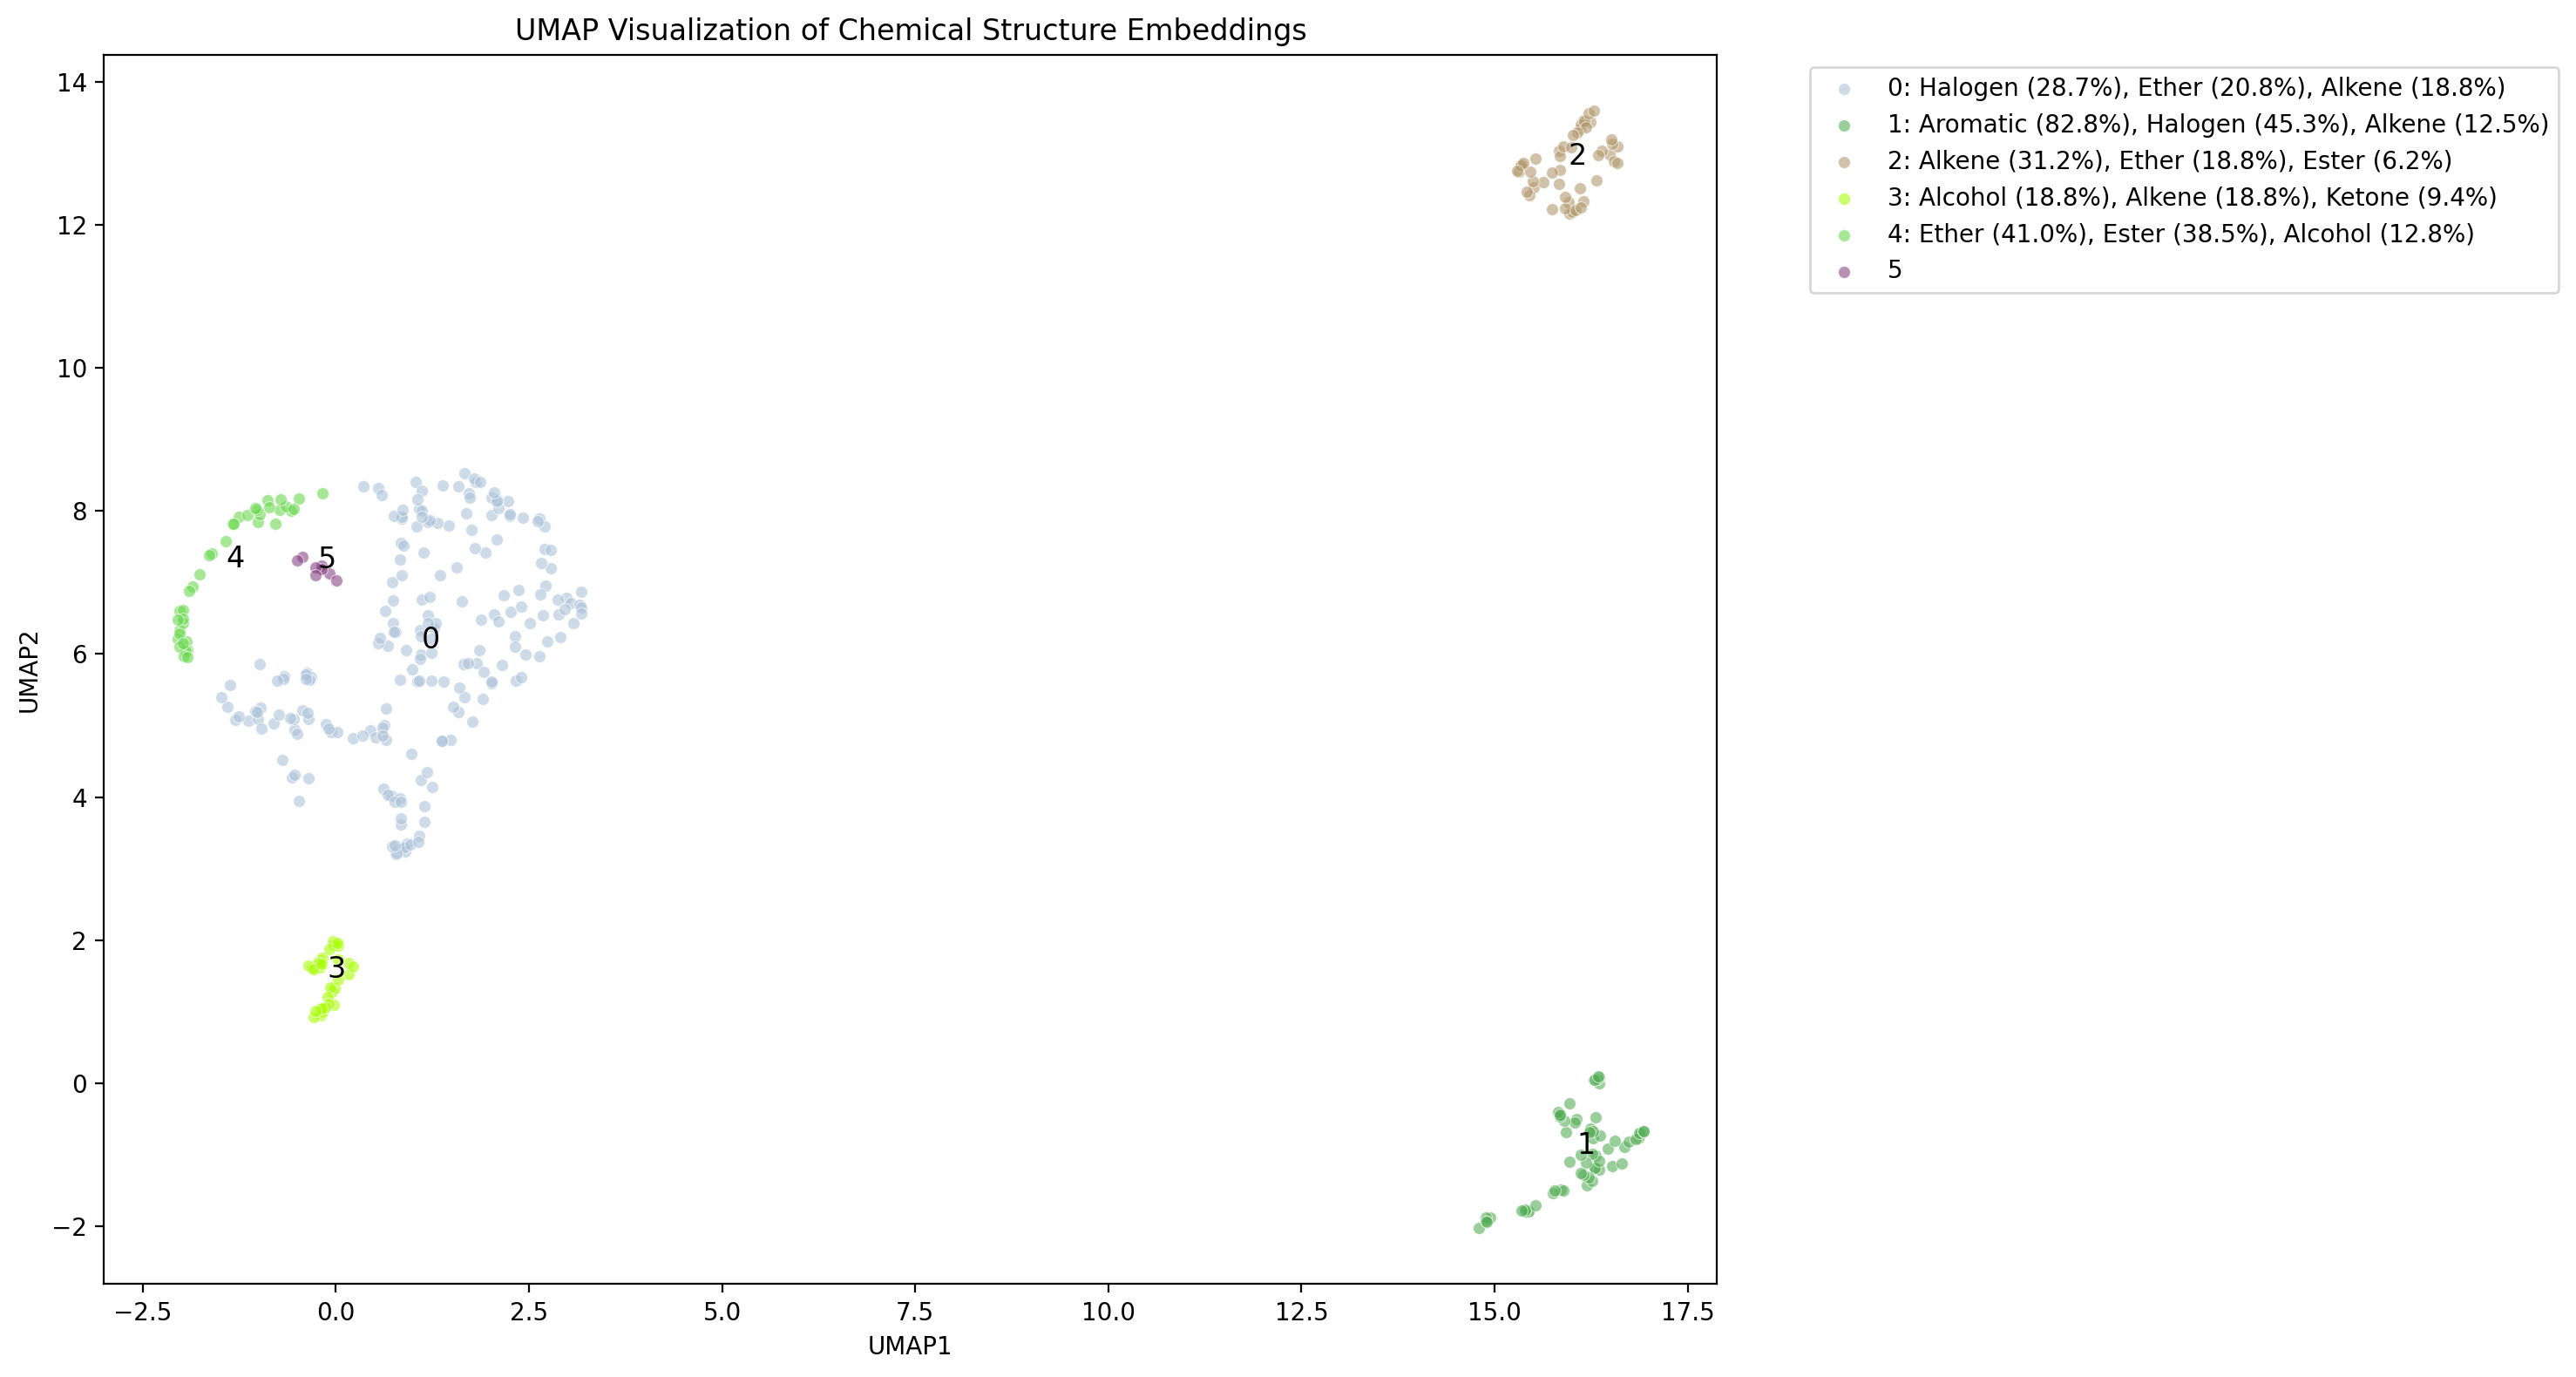

In [192]:
import matplotlib.colors as mcolors

colors = list(mcolors.XKCD_COLORS.keys())

fig, ax = plt.subplots(figsize=(15, 8), dpi=200)

for cluster_id in cluster_analysis.keys():
    cluster_data = cluster_analysis[cluster_id]

    top_groups = sorted(
        cluster_analysis[cluster_id]['functional_groups'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:3]
    # print(cluster_id, top_groups)
    
    legend_text = f"{cluster_id}: "
    for group, freq in top_groups:
        legend_text += f"{group} ({freq:.1%}), "
    legend_text = legend_text[:-2]
    
    sns.scatterplot(
        x=reduced_embeddings[labels == cluster_id][:, 0],
        y=reduced_embeddings[labels == cluster_id][:, 1],
        alpha=0.6,
        s=25,
        ax=ax,
        label=legend_text,
        color=colors[cluster_id],
    )
    
    # place text label on center of cluster
    center = cluster_data['center']
    ax.text(center[0], center[1], f'{cluster_id}', fontsize=12, color='black')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('UMAP Visualization of Chemical Structure Embeddings')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.tight_layout()
save_path = plots_dir / f'{fname}_umap_clusters.pdf'
fig.savefig(save_path, bbox_inches='tight')

print(f"Saved plot to {save_path.name}")
plt.show()

In [179]:
plots_dir / f'{fname}_umap_clusters.png'

PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/tbp_topelements_umap_clusters.png')

In [34]:
reduced_embeddings = None

In [40]:
n_neighbors: int = 15
min_dist: float = 0.1
cluster_eps: float = 0.5
cluster_min_samples: int = 5

# Scale embeddings
print("Scaling embeddings...")
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(X)

# # Perform UMAP
if reduced_embeddings is None:
    print("Performing UMAP reduction...")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=42
    )
    reduced_embeddings = reducer.fit_transform(scaled_embeddings)

# Analyze clusters
print("Analyzing chemical clusters...")
analyzer = ChemicalClusterAnalyzer()
labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
    reduced_embeddings,
    smiles_list,
    eps=cluster_eps,
    min_samples=cluster_min_samples
)

# Create visualization
print("Creating visualization...")
analyzer.plot_cluster_analysis(
    reduced_embeddings,
    smiles_list,
    labels,
    cluster_analysis,
    # output_filepath=vec_dir / f'{fname}_cluster_analysis.html'
)

print("Analysis complete!")

Scaling embeddings...
Analyzing chemical clusters...
Creating visualization...


Analysis complete!


In [65]:
df_plot = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Cluster': labels,
    'SMILES': smiles_list
})

for cluster_id in set(labels):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]

    # Get dominant functional groups for hover text
    if cluster_id in cluster_analysis:
        top_groups = sorted(
            cluster_analysis[cluster_id]['functional_groups'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        print(cluster_id, top_groups)

0 [('Aromatic', 0.690448343079922), ('Alcohol', 0.3563352826510721), ('Ether', 0.2651072124756335)]
1 [('Alkene', 1.0), ('Alcohol', 0.75), ('Carboxylic Acid', 0.25)]
2 [('Aromatic', 0.9265734265734266), ('Halogen', 0.3758741258741259), ('Alcohol', 0.3735431235431235)]
3 [('Aromatic', 0.4878048780487805), ('Halogen', 0.2682926829268293), ('Alcohol', 0.2073170731707317)]
4 [('Alcohol', 0.2872983870967742), ('Halogen', 0.25756048387096775), ('Ether', 0.20463709677419356)]
5 [('Aromatic', 0.9695431472081218), ('Ether', 0.34517766497461927), ('Amide', 0.27411167512690354)]
6 [('Alcohol', 0.375), ('Halogen', 0.125), ('Carboxylic Acid', 0.09821428571428571)]
7 [('Aromatic', 0.9857142857142858), ('Halogen', 0.2857142857142857), ('Alcohol', 0.2714285714285714)]
8 [('Alcohol', 1.0), ('Ether', 0.4634146341463415), ('Aldehyde', 0.3902439024390244)]
9 [('Halogen', 0.8378378378378378), ('Ether', 0.24324324324324326), ('Ester', 0.16216216216216217)]
10 [('Alcohol', 1.0), ('Ether', 1.0), ('Aromatic', 

In [29]:
labels

array([ 0,  1,  1, ..., 17,  0,  1])